In [1]:
import numpy as np
import pandas as pd
import pystan
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('drowning.txt',' ',header=None)
drowns_per_year = df.values

# Mistakes in the STAN code
1. There is no lower bound to sigma, Fix to this is : $real<lower=0>~ sigma$

2. The Y_pred is defined incorrectly, The mean should be taken for the prediction of the current year , Fix to this is:$ypred = normal\_rng(alpha + beta*xpred, sigma);$

In [3]:
stan_code="""
data {
int<lower=0> N; // number of data points
vector[N] x; // observation year
vector[N] y; // observation number of drowned
real xpred; // prediction year
real pmubeta;  // prior mean for beta
real psbeta;   // prior std for beta
}
parameters {
real alpha;
real beta;
real<lower=0> sigma;//FIXED
}
transformed parameters {
vector[N] mu;
mu = alpha + beta*x;
}
model {
beta ~ normal(pmubeta, psbeta);
y ~ normal(mu, sigma);
}
generated quantities {
real ypred;
ypred = normal_rng(alpha+beta*xpred, sigma); //FIXED
}
"""

In [4]:
sm = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_862e35b101f00c814a3153a7fa9ce8e0 NOW.


## Approximating numerical value of $\tau$
WE can calculate the value of $\tau$ numerically using the probability given in the problem
$$ Pr[ \beta \leq -69] + Pr[\beta \geq 69] = 0.01$$
As $\beta \sim N(0,\tau^2)$ the normal distribution is symmetric
$$ 2\cdot Pr[\beta \leq -69] = 0.01$$
$$ Pr[\beta \leq -69] = 0.005$$
Converting this equation from $N(0,\tau^2)$ to one that uses standard normal distribution $N(0,1)$
$$ Pr\left[\frac{\beta-0}{\tau} \leq \frac{-69-0}{\tau}\right] = 0.01$$
$$ Pr\left[N \leq \frac{-69}{\tau}\right] = 0.01$$
We can use the python normal distribution to calculate the inverse CDF to find what $\tau$ should be
$$ \frac{-69}{\tau} = CDF^{-1}(0.01)$$
$$ \tau = \frac{-69}{CDF^{-1}(0.01)}$$

We get the value of $\tau$ as 26.787489335933035 as seen below

In [5]:
from scipy.stats import norm

standard_norm = norm()
# ppf is the inverse CDF function
tau = -69/standard_norm.ppf(0.005)
print("The value of tau is: ",tau)

The value of tau is:  26.787489335933035


## Implementing the desired prior in code
We can incorporate the prior by sending $pmubeta =0$ and $psbeta=\tau$ as the prior distribution variable

In [6]:
data ={
    'N':drowns_per_year.shape[0],
    'x':drowns_per_year[:,0],
    'y':drowns_per_year[:,1],
    'xpred':2019,
    'pmubeta':0,
    'psbeta':26.787489335933035
}

In [7]:
fit = sm.sampling(data=data,iter=1000,chains=4)

D:\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [8]:
print(fit)

Inference for Stan model: anon_model_862e35b101f00c814a3153a7fa9ce8e0.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha  1798.1   33.53 766.04 361.84 1281.7 1796.4 2298.7 3292.9    522    1.0
beta    -0.83    0.02   0.38  -1.58  -1.08  -0.83  -0.57  -0.11    522    1.0
sigma   26.05    0.13   3.18  20.54  23.71  25.75  28.08  32.57    562   1.01
mu[0]  153.01    0.33   8.01 137.48 147.73 153.05 158.16 169.38    592    1.0
mu[1]  152.18    0.31   7.69 137.35 147.13 152.23 157.12 168.06    603    1.0
mu[2]  151.35     0.3   7.37 137.21 146.51 151.38 156.06 166.58    615    1.0
mu[3]  150.52    0.28   7.06 136.95 145.93 150.58  155.1 165.12    630    1.0
mu[4]  149.69    0.27   6.76  136.7 145.26 149.73 154.02 163.62    647    1.0
mu[5]  148.86    0.25   6.46 136.44  144.6  148.9 152.99 162.25    668    1.0
mu[6]  148.02    0.23   6.18 136.

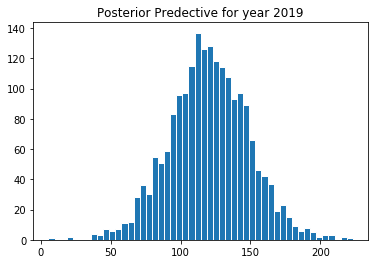

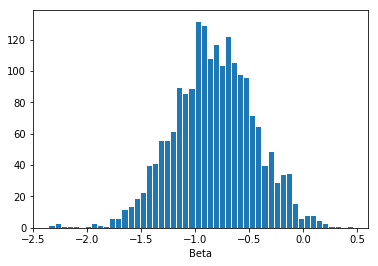

In [11]:
y_pred = fit.extract()['ypred']
plt.hist(y_pred,bins=50,ec='white')
beta = fit.extract()['beta']
plt.title("Posterior Predective for year 2019")
plt.show()
plt.hist(beta,bins=50,ec='white')
plt.xlabel("Beta")
plt.show()

# Second Exercise

In [12]:
factory_data = pd.read_csv('factory.txt',delimiter="\s+",header=None)
factory_data = factory_data.values

In [13]:
factory_data

array([[ 83, 117, 101, 105,  79,  57],
       [ 92, 109,  93, 119,  97,  92],
       [ 92, 114,  92, 116, 103, 104],
       [ 46, 104,  86, 102,  79,  77],
       [ 67,  87,  67, 116,  92, 100]], dtype=int64)

## Separate Model
Here in the separate model we fit one $\mu_j$ and one $\sigma_j$ for each specific machine. Hence the model can be written as :
$$ y_{ij} \mid \mu_j,\sigma_j \sim N(\mu_j,\sigma_j)$$
Where $y_{ij}$ is the $i^{th}$ measurement for the $j^{th}$ machine

In [14]:
factory_model_separate ="""
data {
  int<lower=0> N; // number of data points
  int<lower=0> K; // number of groups
  int<lower=1,upper=K> x[N]; // group indicator
  vector[N] y; //
}
parameters {
  vector[K] mu;        // group means
  vector<lower=0>[K] sigma; // stds
}
model {
  y ~ normal(mu[x], sigma[x]);
}
generated quantities {
real ypred;
ypred = normal_rng(mu[6], sigma[6]);
}
"""


In [15]:
Seperate_model = pystan.StanModel(model_code=factory_model_separate)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0c0813c66cc496f25e489e51efbdd0b2 NOW.


### Fitting the model

In [16]:
sep_data ={
    'N':factory_data.size,
    'K':6,#Number of groups
    'x':list(range(1,7,1))*5,#group indicator
    'y':factory_data.flatten()
}
sep_fit = Seperate_model.sampling(data=sep_data,iter=2000,chains=4)
print(sep_fit)
sep_y_pred = sep_fit.extract()['ypred']
mus = sep_fit.extract()['mu']

Inference for Stan model: anon_model_0c0813c66cc496f25e489e51efbdd0b2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]     76.88    0.51  16.29  47.55  68.71  76.33  84.02 111.64   1024    1.0
mu[1]    107.56    0.88  15.36  85.78 101.58 106.39 111.33 131.76    307   1.01
mu[2]     87.95    0.33  10.15  68.74  82.79  87.71  92.74 107.98    935    1.0
mu[3]    111.52    0.17   6.09  98.95 108.58 111.55 114.57 123.63   1250    1.0
mu[4]      90.5    0.45   11.0  71.76  85.72  90.09  94.67 112.04    596   1.01
mu[5]     86.33    0.49  16.26  52.39  78.43  86.03  93.56 121.32   1119    1.0
sigma[0]  30.83    0.59  18.79  13.18   19.4   25.3  35.11  86.48   1019    1.0
sigma[1]  20.62    1.22  22.35   8.01   12.0   15.6  21.86  61.97    338   1.01
sigma[2]  20.07    0.41  13.67   8.38  12.64  16.54  22.89  53.57   1102    1.0
sigma[3]  1

### i) Posterior distribution for 6th machine
In the separate model as we fit a specific value of $\mu$ and $\sigma$ for each machine we can plot the distribution of $\mu_6$ from the model that we fit .<br>
Hence the histogram below is the distribution of $\mu_6$ that was obtained from the model

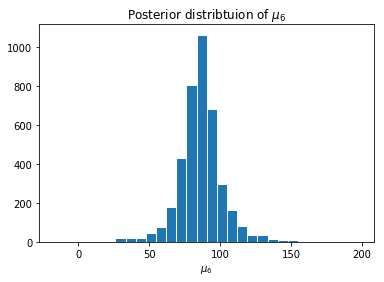

In [17]:
plt.hist(mus[:,5],bins=30,ec='white')
plt.title(r"Posterior distribtuion of $\mu_6$")
plt.xlabel(r"$\mu_6$")
plt.show()

### ii) Predictive distribution for another quality measurement
The distribution is given by the separate parameters mu[5] and sigma[5] and a new value for the 6th machine measurement is given by **ypred**, which we have already defined

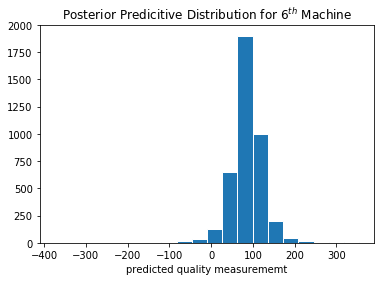

In [18]:
plt.hist(sep_y_pred,ec='white',bins=20)
plt.title(r"Posterior Predicitive Distribution for $6^{th}$ Machine")
plt.xlabel("predicted quality measurememt")
plt.show()

###  iii) Posterior distribution of $\mu$ for 7th Machine
We cannot have a posterior distribution of the 7th machine as **we have no data for the 7th machine**, hence no model that we can draw samples from
Hence there is **no histogram for the 7th Machine** 

## Pooled model

In [19]:
factory_code_pooled ="""
data {
  int<lower=0> N; // number of data points
  vector[N] y; //
}
parameters {
  real mu;        // common mean
  real<lower=0> sigma; // common std
}
model {
  y ~ normal(mu, sigma);
}
generated quantities {
real ypred;
ypred = normal_rng(mu, sigma);
}
"""
pooled_model = pystan.StanModel(model_code=factory_code_pooled)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_aeeaeaf884db0a4618642b545241ecee NOW.


In [20]:
pooled_data={
    'N':factory_data.flatten().shape[0],
    'y':factory_data.flatten()
}
pooled_fit = pooled_model.sampling(data=pooled_data,iter=1000,chains=4)
print(pooled_fit)

Inference for Stan model: anon_model_aeeaeaf884db0a4618642b545241ecee.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu     92.86     0.1   3.72  85.54   90.4   92.9  95.35  99.93   1348    1.0
sigma  19.05    0.08   2.68  14.67  17.14  18.76  20.64   25.0   1165    1.0
ypred  91.95    0.42  18.84  53.33  79.97  92.23 104.85 127.55   2000   1.01
lp__  -99.45    0.04   1.11 -102.4 -99.92 -99.11 -98.63 -98.35    822    1.0

Samples were drawn using NUTS at Sat Nov  3 22:51:45 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### i) Posterior distribution for 6th machine
As the pooled model has no concept of different machines, the posterior distribution of the 6th machine is just the posterior distribution of the model that was fit.
Hence the histogram below is the distribution of $\mu$ that was obtained from the model

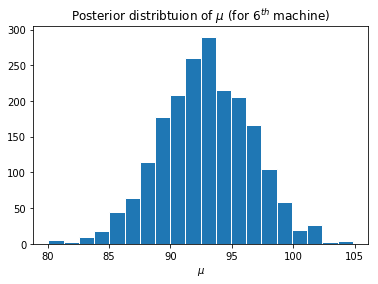

In [21]:
mup = pooled_fit.extract()['mu']
plt.hist(mup,bins=20,ec='white')
plt.title(r"Posterior distribtuion of $\mu$ (for $6^{th}$ machine)")
plt.xlabel(r"$\mu$")
plt.show()

### ii) Predictive distribution for another quality measurement
We cannot derive a measurement for particular 6th machine, since all the model does is fit the data coming from all the machines into a common $\mu$ and $\sigma$.

All that we can do here is predict (in general) another measurement.

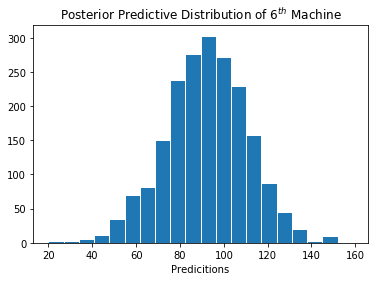

In [22]:
plt.hist(pooled_fit.extract()['ypred'],bins=20,ec="white")
plt.title(r"Posterior Predictive Distribution of $6^{th}$ Machine")
plt.xlabel("Predicitions")
plt.show()


### iii) Posterior distribution of $\mu$ for 7th Machine
As previously mentioned there is no concept of separate machines, hence even for the 7th we can just predict the same distribution of $\mu$ as obtained from our model as there is **no change if we did not have data for the specific machine while fitting the model**.<br>
Hence the histogram below is the distribution of $\mu$ that was obtained from the model.

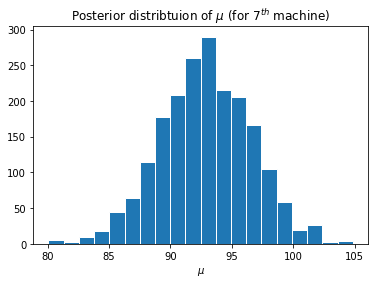

In [23]:
mup = pooled_fit.extract()['mu']
plt.hist(mup,bins=20,ec='white')
plt.title(r"Posterior distribtuion of $\mu$ (for $7^{th}$ machine)")
plt.xlabel(r"$\mu$")
plt.show()

## Hierarchical model
In the hierarchical model we have a mean $\mu$ for every machine and a common $\sigma$ but also we have hyper-parameters $\mu_0$ and $\sigma_0$ as parameters that describe the distribution of $\mu$ for any machine.<br>
Hence the model can be written in two parts as:
$$ \mu_j \mid \mu_0, \sigma_0 \sim N(\mu_0,\sigma_0)$$
$$ y_{ij} \mid \mu_j, \sigma \sim N(\mu_j,\sigma)$$
Where $y_{ij}$ is the $i^{th}$ measurement for the $j^{th}$ machine

#### Stan Model for Hierarchical Model

In [24]:
factory_model_hierachical ="""
data {
  int<lower=0> N; // number of data points
  int<lower=0> K; // number of groups
  int<lower=1,upper=K> x[N]; // group indicator
  vector[N] y; //
}
parameters {
  real mu0;        // group means
  real<lower=0> sigma0; // common std
  vector[K] mu;
  real<lower=0> sigma;
  
}
model {
  mu ~ normal(mu0,sigma0);
  y ~ normal(mu[x], sigma);
}
generated quantities {
  real y_pred;
  real mu_pred;
  real y7_pred;
  y_pred = normal_rng(mu[6],sigma);
  mu_pred = normal_rng(mu0,sigma0);
  y7_pred = normal_rng(mu_pred,sigma);
}
"""

In [25]:
sm_hie = pystan.StanModel(model_code=factory_model_hierachical)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6ba85296d012a0ebc3b438931f194e62 NOW.


### Model Fit

In [26]:
hierarchical_data ={
    'N':factory_data.size,
    'K':6,
    'x':list(range(1,7,1))*5,
    'y':factory_data.flatten()
}
### CHANGE THE ANEM FROM sm_pooled
hier_fit = sm_hie.sampling(data=hierarchical_data,iter=1000,chains=4)
print(hier_fit)
hier_y_pred = hier_fit.extract()['y_pred']
hier_y7_pred = hier_fit.extract()['y7_pred']
hier_mu_pred = hier_fit.extract()['mu_pred']

Inference for Stan model: anon_model_6ba85296d012a0ebc3b438931f194e62.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu0      92.73    0.21   7.38  77.38  88.71  92.84  96.72 107.77   1189    1.0
sigma0   15.53    0.49   8.94    2.5  10.34  13.89  18.89  37.18    334   1.01
mu[0]     80.3    0.43   6.88  67.69  75.38  79.87  84.89  94.59    252   1.01
mu[1]   102.85    0.34   6.62  90.12  98.31 102.68 107.33 115.51    377   1.01
mu[2]    89.14    0.14    6.1  76.46   85.4  89.43  93.16  100.6   2000    1.0
mu[3]   107.15    0.44   6.98  92.29 102.64 107.39 111.83 120.62    257   1.01
mu[4]    90.66    0.14   6.29  77.63  86.55  91.01  94.74 102.97   2000    1.0
mu[5]    87.52    0.17   6.22  74.88  83.51  87.68  91.74 100.08   1309    1.0
sigma    15.26    0.11   2.43  11.34  13.51  14.96  16.76  20.61    508    1.0
y_pred   87.38    0.37 

### Formulation:
$\theta_6$ = p($\mu_6$ | $\mu_6$, $\sigma$) where $\mu_6$ here denotes the the mean for machine 6 and sigma is the common vairance
### Plot of the 6th machine's $\mu$

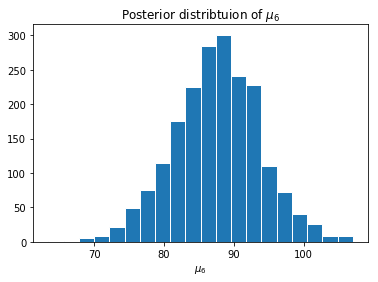

In [27]:
plt.hist(hier_fit.extract()['mu'][:,5],bins=20,ec='white')
plt.title(r"Posterior distribtuion of $\mu_6$")
plt.xlabel(r"$\mu_6$")
plt.show()

### ii) Predictive distribution for another quality measurement

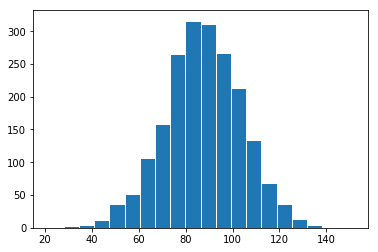

In [28]:
plt.hist(hier_y_pred,bins=20,ec='white')
plt.show()

### iii) Posterior mean distribution of the seventh machine
We first need to sample a mean from the distribution of means and the common variance and then simulate quality predictions.

$\theta_7 = p(\theta_7 | \mu_p, \sigma_p)$


And simulate $y_ij$ with the above parameter 

$y_{ij} = p(y_ij| \theta_7, \sigma)$, where $\sigma$ is the common parameter, as described in the exercise

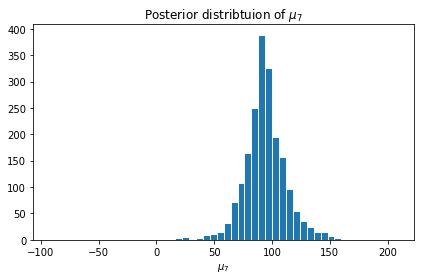

In [29]:
plt.hist(hier_fit.extract()['mu_pred'],bins=50,ec='white')
plt.title("Posterior distribtuion of $\mu_7$")
plt.xlabel(r"$\mu_7$")
plt.tight_layout()
plt.show()

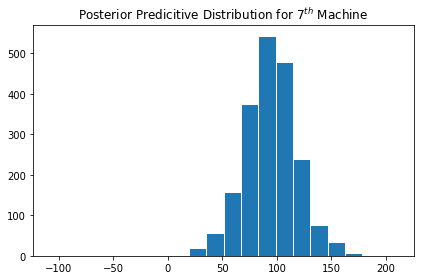

In [30]:
plt.hist(hier_y7_pred,bins=20,ec='white')
plt.title("Posterior Predicitive Distribution for $7^{th}$ Machine")
plt.tight_layout()
plt.show()